This notebook allows easy use of my github repository to find conceptual direction in langguage models.

How to use:
* Sections _Importation_ and _Load Data_ are just used to setup the model and the datasets.
* Section _Learning and Testing Hyperplanes_ allows you to test if we can extract a separating hyperplane for gender from the activations of the model.
* Section _Steer and Erasure_ allows you to test erasing and steering the model's notion of gender with various hyperparameters.
* Sections _Learning and Testing Directions_ and _Continuation Modifications_ are still in progress.

# Installation



Import GPT2-xl with the available RAM. Setup and import all important packages.\
If you want to use gpt2-xl, set gpt_small to False.

In [1]:
gpt_small = True #True for gpt2-small, False for gpt2-xl
import sys
in_colab = 'google.colab' in sys.modules

In [2]:
#import the useful libraries if you are working on google colab
if in_colab:
    !git clone https://github.com/leodana2000/finding_gender_direction.git
    !pip install transformers
    !pip install accelerate

In [3]:
if in_colab:
    sys.path.append("/content/finding_gender_direction")
else:
    PATH = "/finding_gender_direction/"
    sys.path.append(PATH)

from hyperplane_computation import utils
from hyperplane_computation.inference_time_modif import score
from hyperplane_computation import store_test_hyperplane
from Data.type import DataStorage

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.set_grad_enabled(False)

if gpt_small:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
  model = GPT2LMHeadModel.from_pretrained('gpt2')
else:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-xl')
  model = GPT2LMHeadModel.from_pretrained('gpt2-xl', device_map="auto", offload_folder="offload", offload_state_dict=True)

model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)
tokenizer.pad_token = tokenizer.eos_token

dict = {
    'device': device,
    'model': model,
    'tokenizer': tokenizer,
}

# Load Data

In [6]:
batch_size = 1024
rand_seed = 42
train_test_ratio = 0.85

if in_colab:
    D = pd.read_csv("finding_gender_direction/Data/Train_Data.csv")
else:
    D = pd.read_csv("Data/Train_Data.csv")

dataset = DataStorage(
    D,
    batch_size=batch_size,
    rand_seed=rand_seed,
    train_test_ratio=train_test_ratio,
)

In [7]:
if in_colab:
    Test = pd.read_csv("finding_gender_direction/Data/Test_Data.csv")
else:
    Test = pd.read_csv("Data/Test_Data.csv")

examples_A = Test[Test['data_num'] == 'a'][['question', 'bin', 'target']].values.tolist()
examples_B = Test[Test['data_num'] == 'b'][['question', 'bin', 'target']].values.tolist()
examples_C = Test[Test['data_num'] == 'c'][['question', 'bin', 'target']].values.tolist()
examples_D = Test[Test['data_num'] == 'd'][['question', 'bin', 'target']].values.tolist()

#Since the test sets for names are much larger than for nouns, we select a subset of same size, and with the same parity.
examples_C = utils.select_rand(examples_C, len(examples_B), rand_seed)
examples_D = utils.select_rand(examples_D, len(examples_A), rand_seed)

examples_A = [list(row) for row in zip(*examples_A)]
examples_B = [list(row) for row in zip(*examples_B)]
examples_C = [list(row) for row in zip(*examples_C)]
examples_D = [list(row) for row in zip(*examples_D)]

examples = [examples_A, examples_B, examples_C, examples_D]

In [8]:
#list of tokens counted as "good" answers
text_lists = [["he", " he", "He", " He",
                 "him", " him", "Him", " Him",
                 "his", " his", "His", " His",
                 "male", " male", "Male", " Male",
                 "son", " son", "Son", " Son",
                 "father", " father", "Father", " Father",
                 "boy", " boy", "Boy", " Boy",
                 ],
              ["she", " she", "She", " She",
               "her", " her", "Her", " Her",
               "female", " female", "Female", " Female",
               "daugther", " daugther", "Daugther", " Daugther",
               "mother", " mother", "Mother", " Mother",
               "girl", " girl", "girl", " girl",]]
token_lists = [tokenizer(text_list).input_ids for text_list in text_lists]
token_lists = [[[token[0]] for token in token_lists[0]], [[token[0]] for token in token_lists[1]]]

# Learning and Testing Hyperplane

We learn the gender direction using the difference in mean, using a diff-mean quantile method, and using Logistic Regression. 

We can learn on the full dataset, or only on a subset: for the full, use $Data$, otherwise $Train$. For the second dataset, we want to use $Train_2$ because $Test_2 = Data_2-Train_2$. 

In [9]:
Learn = dataset.get_ex('learn', multi_dim=False)

# Learn the estimators on the attention
eraser_mean, eraser_quantile, eraser_probe = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm=True, learn_probe=True, **dict)

Train = dataset.get_ex('train', multi_dim=False)

# Learn the estimators on the attention
eraser_mean_train, eraser_quantile_train, eraser_probe_train = store_test_hyperplane.storing_hyperplanes(Train, post_layer_norm=True, learn_probe=True, **dict)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 12/12 [00:31<00:00,  2.67s/it]


We can now measure, at each layer, the accuracy of our hyperplane! 

In [10]:
metric_q = utils.probe_eval(eraser_quantile, **dict)
metric_m = utils.probe_eval(eraser_mean, **dict)
metric_p = utils.probe_eval(eraser_probe, **dict)

acc_data_1 = store_test_hyperplane.hyperplane_acc(Learn, [metric_q, metric_m, metric_p], **dict)

Test = dataset.get_ex('test', multi_dim=False)

metric_q = utils.probe_eval(eraser_quantile_train, **dict)
metric_m = utils.probe_eval(eraser_mean_train, **dict)
metric_p = utils.probe_eval(eraser_probe_train, **dict)

acc_data_2 = store_test_hyperplane.hyperplane_acc(Test, [metric_q, metric_m, metric_p], **dict)

100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


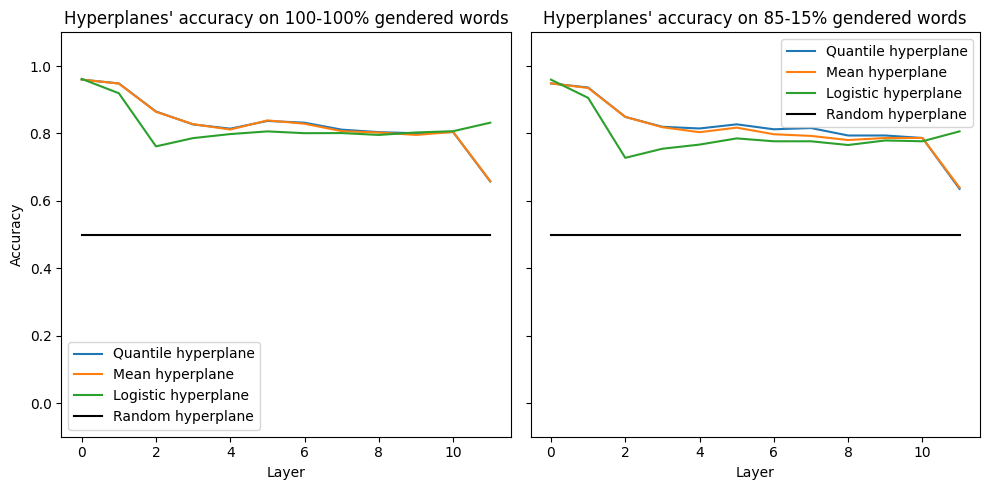

In [11]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex = True, sharey = True)

axes[0].plot(acc_data_1[0], label = 'Quantile hyperplane')
axes[0].plot(acc_data_1[1], label = 'Mean hyperplane')
axes[0].plot(acc_data_1[2], label = 'Logistic hyperplane')
axes[0].plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes[0].set_title("Hyperplanes' accuracy on 100-100% gendered words")
axes[0].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(-0.1, 1.1)
axes[0].legend()

axes[1].plot(acc_data_2[0], label = 'Quantile hyperplane')
axes[1].plot(acc_data_2[1], label = 'Mean hyperplane')
axes[1].plot(acc_data_2[2], label = 'Logistic hyperplane')
axes[1].plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes[1].set_title("Hyperplanes' accuracy on {}-{}% gendered words".format(int(100*train_test_ratio), int(100*(1-train_test_ratio))))
axes[1].set_xlabel("Layer")
axes[1].set_ylim(-0.1, 1.1)
axes[1].legend()

plt.tight_layout()
plt.show()

# Steer and Erasure

In [12]:
#Visualise if the test examples have good probability / accuracy
prompts = examples_A
test_prompt = False

if test_prompt:
  tokenized_sentences = [tokenizer(prompt, return_tensors = 'pt')["input_ids"].to(device) for prompt in prompts]

  for tokenized_sentence, prompt in zip(tokenized_sentences, prompts):
    print(prompt)
    print(utils.show_proba(torch.softmax(model(tokenized_sentence).logits[0, -1], dim = -1), nb_tokens = 5, decode = True, **dict))

In [9]:
#We compute all of the leace fitters and erasers
nb_layers = len(model.transformer.h)
layer_list = [[1,2],[3,4]] #[[i for i in range(0, nb_layers)]]
layer_res_list = [[],[]]
lbds = torch.Tensor([i/10 for i in range(0, 21, 1)])

res_needed = len(layer_res_list[0]) > 0

In [10]:
Learn = dataset.get_ex('learn', multi_dim=True)

#Learning the estimators in the residual stream
flag = True
if flag:
  eraser_mean, eraser_quantile, _ = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm=True, learn_probe=False, **dict)
  flag = False

if res_needed:
    eraser_mean_res, eraser_quantile_res, _ = store_test_hyperplane.storing_hyperplanes(Learn, post_layer_norm=False, learn_probe=False, **dict)
else:
    eraser_mean_res, eraser_quantile_res = None, None

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 12/12 [00:27<00:00,  2.30s/it]


In [11]:
#ToDo: ajouter la binarité directement pour le calcul de l'accuracy et de la probabilité à l'intérieur de l'algo.
score_mix = score(
    examples, token_lists, eraser_mean, eraser_mean_res, 
    layer_list, layer_res_list, lbds = lbds, **dict
)

Batch 0.


100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Batch 1.


100%|██████████| 21/21 [00:43<00:00,  2.05s/it]


Batch 2.


100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


Batch 3.


100%|██████████| 21/21 [00:51<00:00,  2.44s/it]


torch.Size([2, 2, 21])


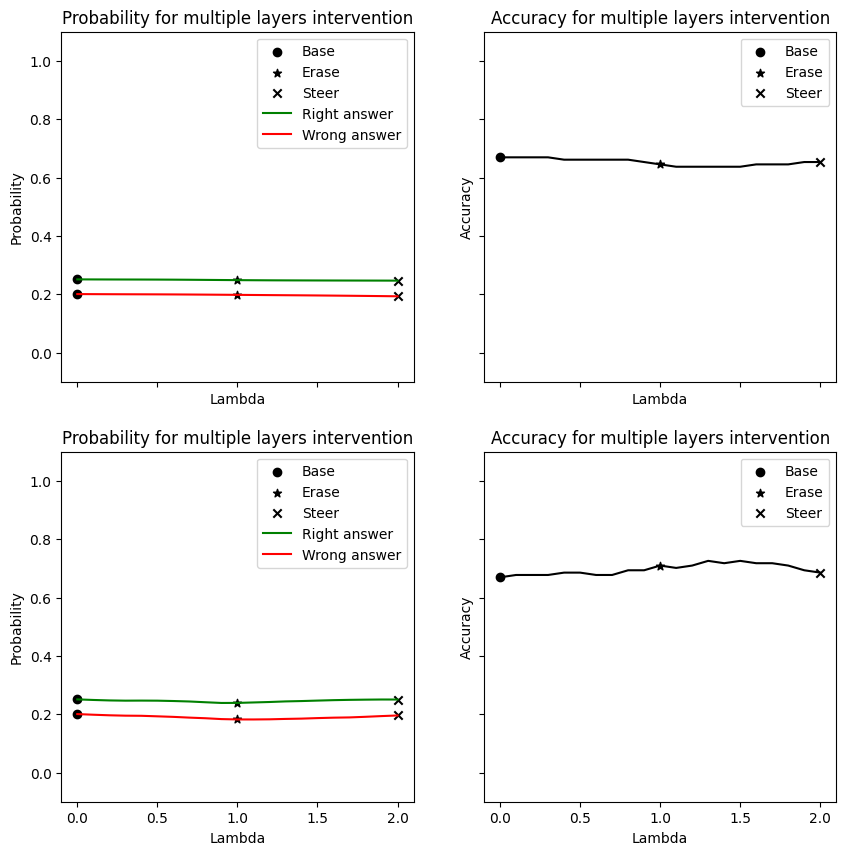

In [16]:
# Plots the graphs depending if we intervene in the attention or not.
# proba has shape [experiments, binary, lbds]
probas, accs = score_mix
nb_exp = accs.shape[0]

fig, axes = plt.subplots(nb_exp, 2, figsize=(10, 5*nb_exp), sharex = True, sharey = True)

for i, (proba, acc) in enumerate(zip(probas, accs)):
    axes[i][0].scatter([0, 0], [proba[0][0], proba[1][0]], color = "k", label = 'Base')
    axes[i][0].scatter([1, 1], [proba[0][10], proba[1][10]], color = 'k', label = 'Erase', marker = "*")
    axes[i][0].scatter([2, 2], [proba[0][20], proba[1][20]], color = 'k', label = 'Steer', marker = "x")
    axes[i][0].plot(lbds, proba[0], color = 'green', label = "Right answer")
    axes[i][0].plot(lbds, proba[1], color = 'red', label = "Wrong answer")

    axes[i][0].legend()
    axes[i][0].set_title("Probability for multiple layers intervention")
    axes[i][0].set_xlabel("Lambda")
    axes[i][0].set_ylabel("Probability")
    axes[i][0].set_ylim(-0.1, 1.1)

    axes[i][1].scatter([0], [acc[0]], color = "k", label = 'Base')
    axes[i][1].scatter([1], [acc[10]], color = 'k', label = 'Erase', marker = "*")
    axes[i][1].scatter([2], [acc[20]], color = 'k', label = 'Steer', marker = "x")
    axes[i][1].plot(lbds, acc, color = 'black')
    axes[i][1].set_xlabel("Lambda")
    axes[i][1].set_title("Accuracy for multiple layers intervention")
    axes[i][1].set_ylabel("Accuracy")
    axes[i][1].legend()

In [ ]:
#If the code is interupted while a hook is running, this will reset back the model to normal.
for module in model.transformer.h:
  module._forward_pre_hooks.clear()
  module.attn._forward_pre_hooks.clear()
  module.attn._forward_hooks.clear()

# Learning and Testing Directions

Similarly to the last section, we learn the leace and Logistic direction but this time on pairs of example instead of examples directly.\ 
$Y = X_{male} - X_{female}$\
\
Thus:
* we need paired examples, thus we can't use the dataset 2,
* we have $b_{mean} = b_{quantile} = 0$,

In [ ]:
eraser_dir_mean_1, eraser_dir_probe_1 = store_test_hyperplane.storing_directions([[Data_m_1], [Data_f_1]], post_layer_norm = True, **dict)

In [ ]:
metric_m = utils.leace_eval(eraser_dir_mean_1)
metric_p = utils.leace_eval(eraser_dir_probe_1)

acc_data = store_test_hyperplane.direction_acc([[word[0] for word in Data_m_1], [word[0] for word in Data_f_1]], [metric_m, metric_p], **dict)

In [ ]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex = True, sharey = True)

axes.plot(acc_data[0], label = 'Mean direction', color = 'C1')
axes.plot(acc_data[1], label = 'Logistic direction', color = 'C2')
axes.plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random direction')
axes.set_title("Directions' accuracy on gendered words")
axes.set_xlabel("Layer")
axes.set_ylabel("Accuracy")
axes.set_ylim(-0.1, 1.1)
axes.legend()

plt.tight_layout()
plt.show()

# Continuation Modification

We test here the modification of the sentence at inference time. \
Given a sentence, and words to intervene on, we look at continutations to see if there is any effect or not. \
\
WORK IN PROGRESS

In [ ]:
#function to make gpt2 output sentence and have a modification (writing or erasing)

def hook_spe(lbd, stream_indices, example_indices):
  def meta_hook(leace_eraser):
    def hook(module, input):
      if input[0].shape[1] != 1:
        input[0][example_indices, stream_indices] -= lbd*leace_eraser.proj_left.T*((input[0][example_indices, stream_indices]-leace_eraser.bias)@leace_eraser.proj_right.T)
      return input
    return hook
  return meta_hook

def hook_spe_attn(stream_indices, example_indices, stream_example_indices):
  def meta_hook(hookk):
    def hook(module, input, output):
      if input[0].shape[1] != 1:
        return inference_time_modification.attn_forward(module, input[0], hookk, stream_indices, example_indices, stream_example_indices)
      else:
        return output
    return hook
  return meta_hook

def generate_hook(example : str, target_text : list[str], nb_sequences : int,
                  max_len : int, hook_layer = [],
                  leace_eraser = None, lbd = 1):

  example_tokens = tokenizer(example, return_tensors = 'pt')["input_ids"].to(device)
  target_tokens = [tokenizer(text).input_ids for text in target_text]
  stream_indices, example_indices, stream_example_indices = utils.finds_indices(example_tokens, target_tokens)

  hook_flag = []
  for layer in hook_layer:
    hook_flag.append(model.transformer.h[layer].attn.register_forward_hook(
                    hook_spe_attn(stream_indices, example_indices, stream_example_indices)(hook_spe(lbd, stream_indices, example_indices)(leace_eraser[layer]))
                    ))

  torch.manual_seed(0)
  sentences = [tokenizer.batch_decode(model.generate(example_tokens,
                                                     max_length = max_len + example_tokens.shape[-1],
                                                     do_sample = False,
                                                     num_return_sequences = 1))]

  for flag in hook_flag:
    flag.remove()

  return sentences

In [ ]:
sentence = "He is so pretty, I want to ask"
target_text = ['He']
hook_layer = [i for i in range(0, 48)]
nb_max_tokens = 20
lbds = [0, 1, 2]

for module in model.transformer.h:
  module.attn._forward_hooks.clear()

sentence = [generate_hook(tokenizer.eos_token + sentence,target_text, 1, nb_max_tokens,
                               hook_layer = hook_layer, leace_eraser = eraser_mean_1, lbd = lbd) for lbd in lbds]

print(f"For layer {hook_layer[0]} to {hook_layer[-1]}, \n", lbds, "\n", np.array(sentence))

NameError: name 'eraser_mean_1' is not defined